### Imports

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

### Dataset Import and Inspection

In [ ]:
df = pd.read_csv('movie.csv')
# Display the head of the dataframe
print('DataFrame Head:')
print(df.head())

# Display the column information
print('\nDataFrame Info:')
df.info()

DataFrame Head:
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


### Text Preprocessing: Case Folding, Punctuation/HTML Removal, Stop Word Removal, and Lemmatization

In [46]:
# Download NLTK resources (if not already downloaded)
# Only runs the download if the resource is missing
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer()
except LookupError:
    nltk.download('wordnet')

print("NLTK setup complete.")

NLTK setup complete.


In [47]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Applies case folding, HTML/punctuation removal, stop word removal, and lemmatization."""
    
    # 1. HTML Tag Removal (Addressing data specific noise like <br />)
    text = re.sub(r'<[^>]*>', '', text)
    
    # 2. Case Folding
    text = text.lower()
    
    # 3. Punctuation and Non-Alphabetic Character Removal (replaces with space)
    # This also removes numbers, which are typically noise in text classification
    text = re.sub(r'[^a-z\s]', ' ', text)
    
    # Tokenize by splitting on spaces
    words = text.split()
    
    # 4. Stop Word Removal and Lemmatization
    processed_words = []
    for word in words:
        # Skip empty strings resulting from multiple spaces and check for stop words
        if word and word not in stop_words:
            # 5. Lemmatize (default assumes word is a noun, 'n')
            lemmatized_word = lemmatizer.lemmatize(word)
            processed_words.append(lemmatized_word)
            
    # Rejoin the words into a single string
    return ' '.join(processed_words)

print("Preprocessing function defined.")

Preprocessing function defined.


In [48]:
print("Applying preprocessing to the 'text' column...")
# Apply the function to the 'text' column and store the result in a new column
df['processed_text'] = df['text'].apply(preprocess_text)
print("Preprocessing complete.")

Applying preprocessing to the 'text' column...
Preprocessing complete.


In [49]:
print("Processed DataFrame Head:")
print(df[['text', 'processed_text', 'label']].head())

Processed DataFrame Head:
                                                text  \
0  I grew up (b. 1965) watching and loving the Th...   
1  When I put this movie in my DVD player, and sa...   
2  Why do people who do not know what a particula...   
3  Even though I have great interest in Biblical ...   
4  Im a die hard Dads Army fan and nothing will e...   

                                      processed_text  label  
0  grew b watching loving thunderbird mate school...      0  
1  put movie dvd player sat coke chip expectation...      0  
2  people know particular time past like feel nee...      0  
3  even though great interest biblical movie bore...      0  
4  im die hard dad army fan nothing ever change g...      1  


### TF-IDF Vectorization

In [50]:
# Initialize the TfidfVectorizer
# We will use the 'processed_text' column for vectorization.
vectorizer = TfidfVectorizer(max_features=None) 

# Fit and transform the processed text data
X_features = vectorizer.fit_transform(df['processed_text'])

# Display the shape of the resulting feature matrix
print(f"Shape of TF-IDF Matrix (Documents x Features): {X_features.shape}")
print("The TF-IDF matrix (X_features) is a sparse matrix of size {} x {}.".format(X_features.shape[0], X_features.shape[1]))

Shape of TF-IDF Matrix (Documents x Features): (40000, 83338)
The TF-IDF matrix (X_features) is a sparse matrix of size 40000 x 83338.


### Data Splitting for Training and Testing

In [51]:
# Extract the feature matrix X and the labels y
X = X_features
y = df['label']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data splitting complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data splitting complete.
X_train shape: (32000, 83338)
X_test shape: (8000, 83338)
y_train shape: (32000,)
y_test shape: (8000,)


### Model Training: Naive Bayes Classifier

In [52]:
# Initialize the Multinomial Naive Bayes model (suited for count/frequency features like TF-IDF)
nb_model = MultinomialNB()

# Train the model using the training data
print("Training Naive Bayes model...")
nb_model.fit(X_train, y_train)
print("Model training complete.")

Training Naive Bayes model...
Model training complete.


### Model Evaluation

Model Accuracy: 0.8656

Confusion Matrix:
 [[3509  457]
 [ 618 3416]]

Classification Report:
               precision    recall  f1-score   support

Negative (0)       0.85      0.88      0.87      3966
Positive (1)       0.88      0.85      0.86      4034

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



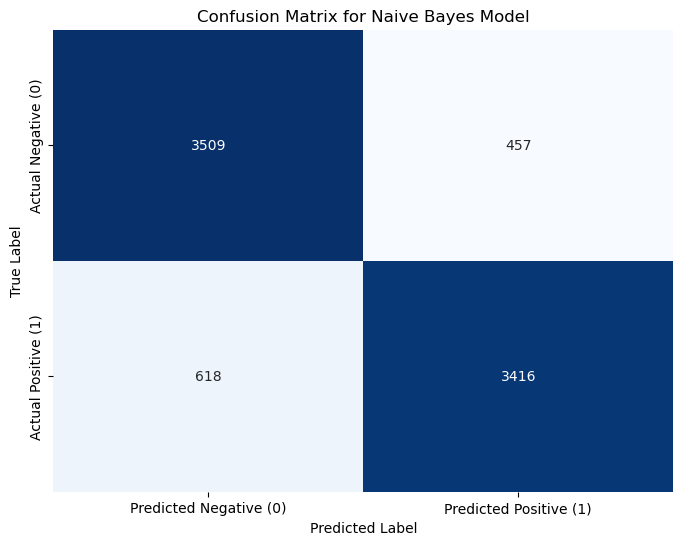

In [53]:
# 1. Make predictions on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)'])

print(f"Model Accuracy: {accuracy:.4f}\n")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative (0)', 'Predicted Positive (1)'],
            yticklabels=['Actual Negative (0)', 'Actual Positive (1)'])
plt.title('Confusion Matrix for Naive Bayes Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()